## Goal of Models and Data

We plan to train two model that will work sequentially, one model will input raw mammogram images and attempt to output the shape of the mass detected in the image as a mask image. The masked images are already provided as a target variable. We will then take the output of the first model and run it through a classifier model to determine the class of the masked image: benign, malignant, or normal (cyst / non-cancerous growth).

In [ ]:
import tensorflow as tf
import numpy as np
import seaborn as sns
import pandas as pd
import random
import matplotlib.pyplot as plt
import pathlib
import cv2
import string
from sklearn.model_selection import train_test_split
import os
from google.colab import drive

drive.mount('/content/drive')
!ls "/content/drive/MyDrive/BreastCancerProject/Datasets"

dir = '/content/drive/MyDrive/BreastCancerProject/Datasets'
datasetpath = os.path.join(dir, 'mammograms_2')

Mounted at /content/drive
 Mammograms   mammograms_2  'Potential Breast Cancer Datasets.docx'


In [ ]:
class read_dataset:
    def __init__(self, datasetpath, imageShape):
        self.datasetpath = datasetpath
        self.imageShape = imageShape

    def images_path(self, folder, name):
        images = list(pathlib.Path(os.path.join(self.datasetpath, folder)).glob('*{}.*'.format(name)))
        return images

    def read_images(self, images, channels):
        listImages = []
        images = np.sort(images)
        for image in images:
            image = tf.io.read_file(str(image))
            image = tf.image.decode_png(image, channels=channels)
            image = tf.image.resize(image, self.imageShape)
            image = image / 255.0
            listImages.append(image)
        return listImages

    def full_dataset(self, label):
        images = self.read_images(self.images_path(label, name=')'), channels=3)
        masks = np.array(self.read_images(self.images_path(label, name='mask'), channels=1))
        masks = (masks >= 0.5).astype('int32')
        return np.array(images), masks

    def final_dataset(self, labels):
        benign_images, benign_masks = self.full_dataset(labels[0])
        malignant_images, malignant_masks = self.full_dataset(labels[1])
        normal_images, normal_masks = self.full_dataset(labels[2])
        masks = np.vstack([benign_masks, malignant_masks, normal_masks])
        images = np.vstack([benign_images, malignant_images, normal_images])
        labels = np.hstack([
            np.ones(shape=(len(benign_images),)) * 0,
            np.ones(shape=(len(malignant_images),)) * 1,
            np.ones(shape=(len(normal_images),)) * 2
        ])
        return images, masks, labels

dataset_obj = read_dataset(datasetpath, [256, 256])
images, masks, labels = dataset_obj.final_dataset(['benign', 'malignant', 'normal'])

indices = np.random.permutation(len(images))
images = images[indices]
masks = masks[indices]
labels = labels[indices]

## Data Shape

The image data in RGB format, and the mask data is in greyscale which should be accounted for when considering running the model, as the output of the mask in training cannot be in RGB format.

In [ ]:
print('Shape of original mammogram dataset:', images.shape)
print('Shape of mask dataset:', masks.shape)
print('Shape of label dataset:', labels.shape)

Shape of original mammogram dataset: (1090, 256, 256, 3)
Shape of mask dataset: (1090, 256, 256, 1)
Shape of label dataset: (1090,)


## Data Samples

There are 1090 total samples in this dataset (original raw feature images). Of the three classes, there are 277 benign images, 315 malignant images, and 498 normal images (do not contain a growth, or contain non-cancerous cysts /
growths).

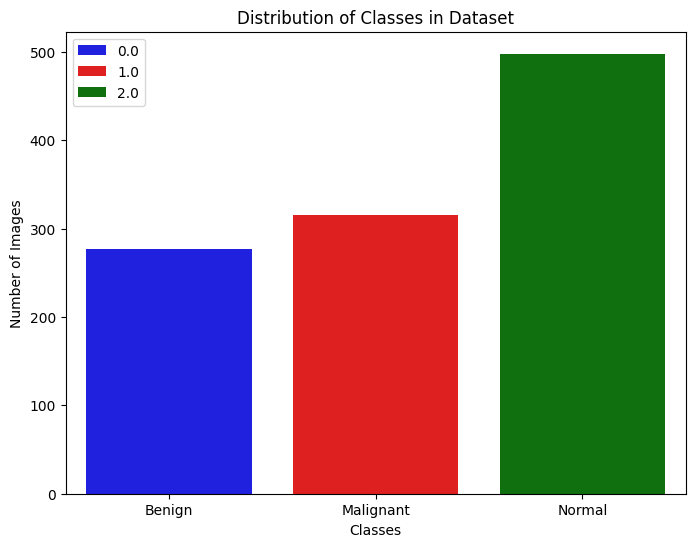

In [ ]:
unique_labels, label_counts = np.unique(labels, return_counts=True)
plt.figure(figsize=(8, 6))
sns.barplot(x=unique_labels, y=label_counts, hue=unique_labels, palette=['blue', 'red', 'green'])
plt.xticks(unique_labels, ['Benign', 'Malignant', 'Normal'])
plt.xlabel("Classes")
plt.ylabel("Number of Images")
plt.title("Distribution of Classes in Dataset")
plt.show()

## Data Visualization

Overlaying the masked images (target values) on the original mammograms (feature values). The masked images are essentially the outline of the growth shown in the images. Some images do not contain a growth of any sort and those will all be classified as normal (some normal images have non-cancerous growths).

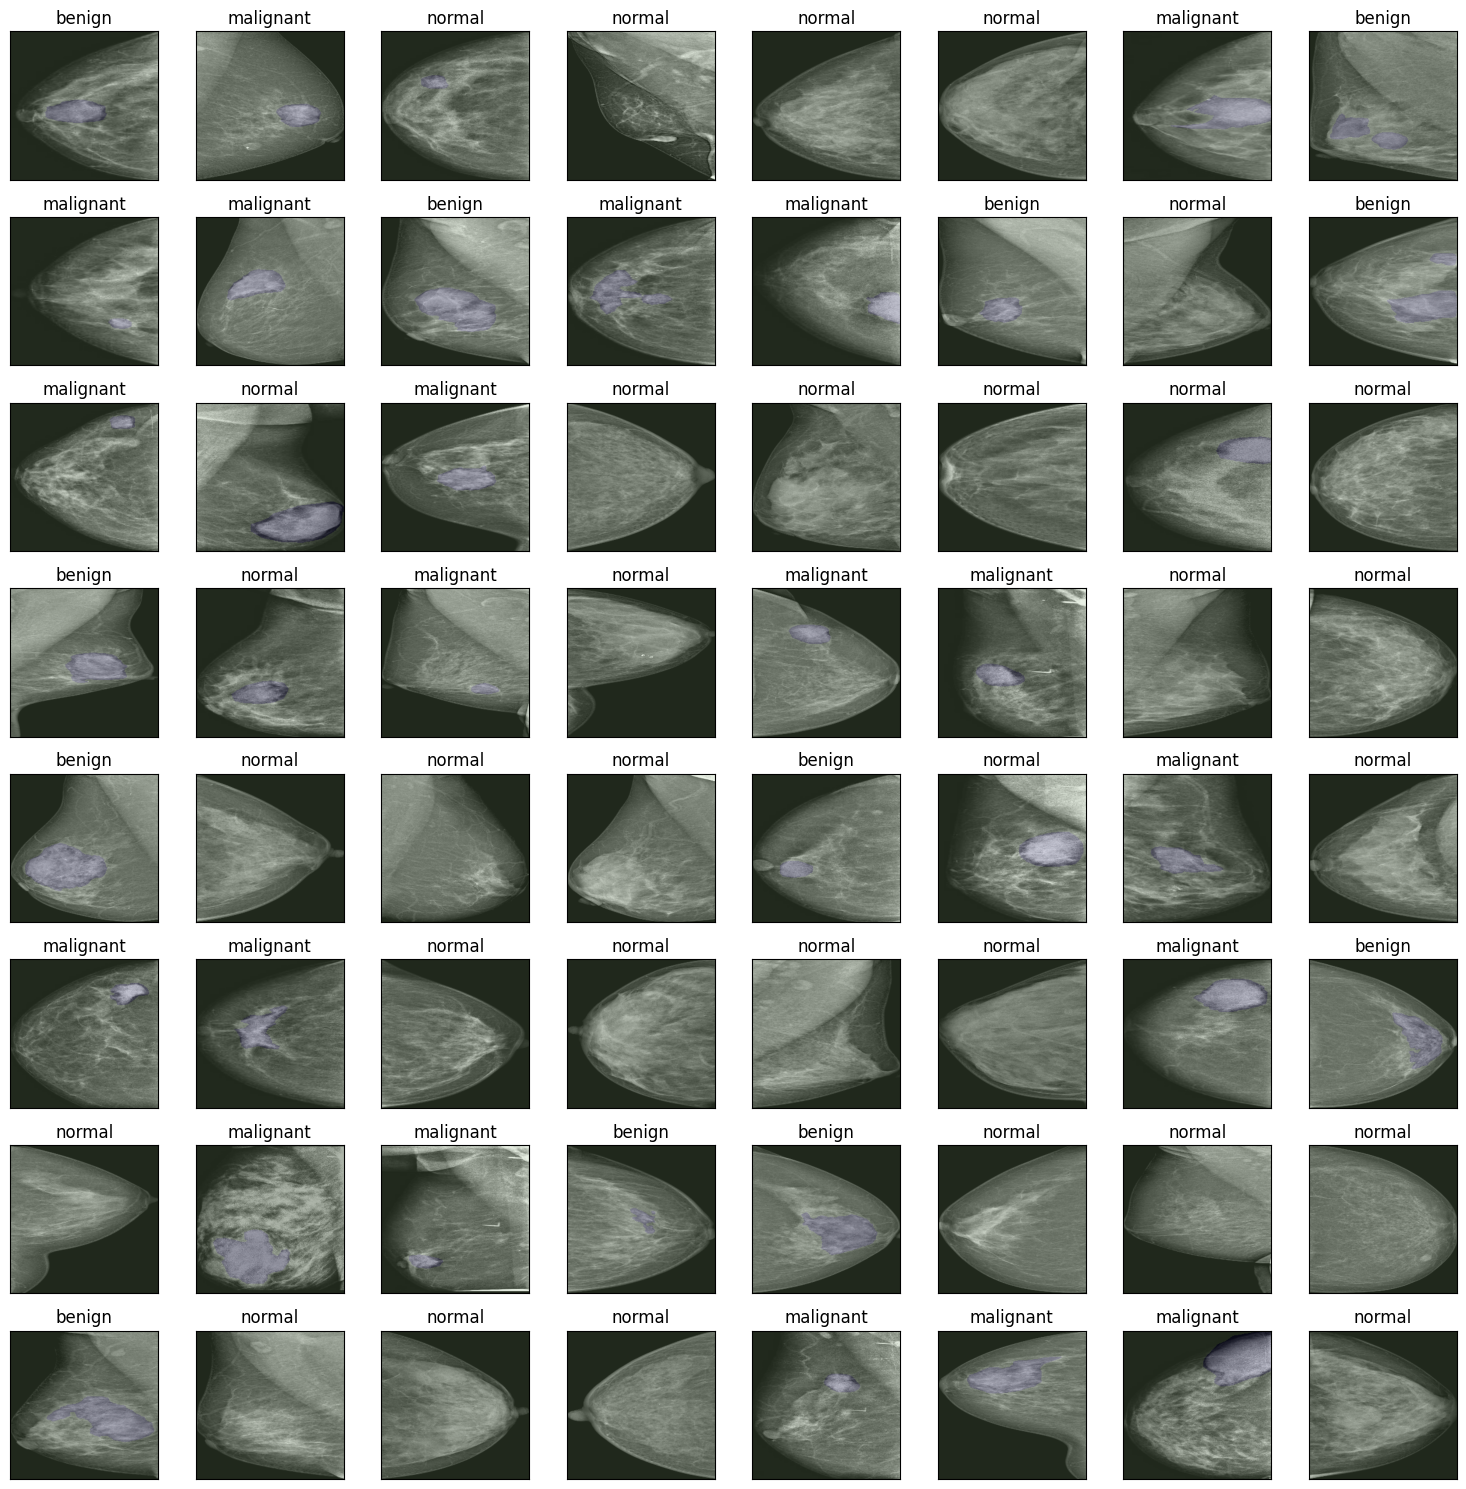

In [ ]:
def labeler(labels):
    if labels == 0:
        return 'benign'
    elif labels == 1:
        return 'malignant'
    else:
        return 'normal'

def plot_random_images(images, masks, labels, num_images=100):
    num_images = min(num_images, images.shape[0], masks.shape[0])
    random_indices = random.sample(range(images.shape[0]), num_images)

    plt.figure(figsize=(15, 15))
    for i, index in enumerate(random_indices):
        plt.subplot(8, 8, (i + 1))
        plt.imshow(images[i])
        plt.imshow(masks[i], alpha=0.2, cmap='crest')
        plt.xticks([])
        plt.yticks([])
        plt.title(labeler(labels[i]))

    plt.tight_layout()
    plt.show()

plot_random_images(images[:64], masks[:64], labels[:64])

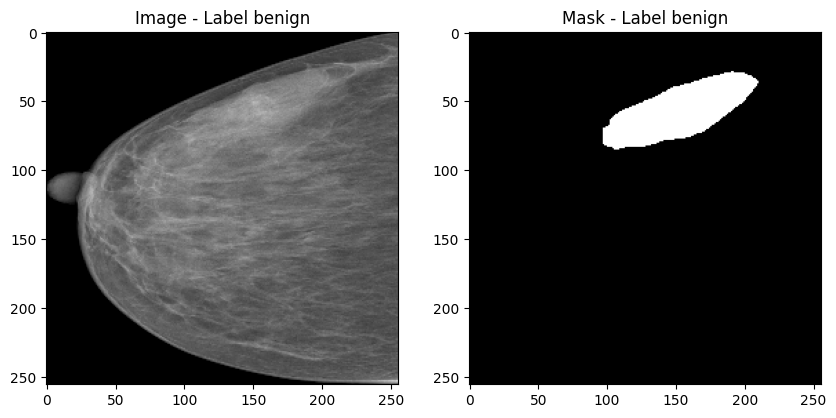

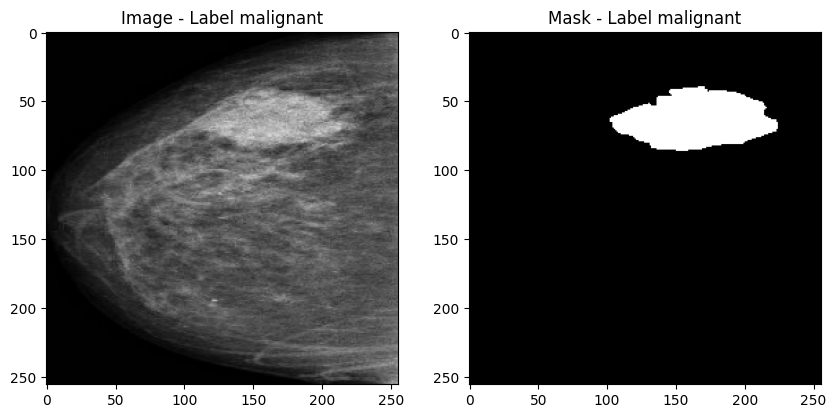

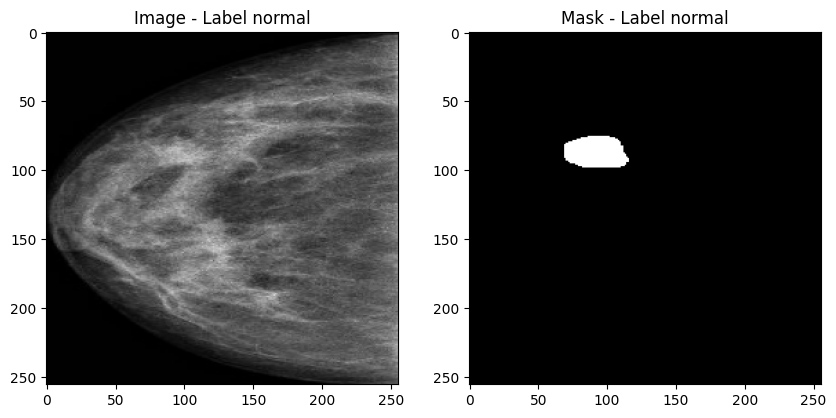

In [ ]:
def plot_images_masks(label, num_images=1):
    label_indices = np.where(labels == label)[0]
    random_indices = np.random.choice(label_indices, size=min(num_images, len(label_indices)), replace=False)

    for i, index in enumerate(random_indices):
        plt.figure(figsize=(10, 5))

        plt.subplot(1, 2, 1)
        plt.imshow(images[index])
        plt.title(f'Image - Label {labeler(label)}')

        plt.subplot(1, 2, 2)
        plt.imshow(np.squeeze(masks[index]), cmap='grey')
        plt.title(f'Mask - Label {labeler(label)}')

        plt.show()

plot_images_masks(0)
plot_images_masks(1)
plot_images_masks(2)

## Train, Validation, and Test Split

We decided to manually create the train test split since the data was already randomized previously during pre-processing, and we were having difficulties with the packaged train/test split functions. This split features 70% training data, 15% validation data and, 15% test data. Since the dataset is relatively small, we needed to allocate as much data as possible to training to avoid issues with the model such as underfitting.



In [ ]:
n = len(images)
train = int(n * 0.7)
val = int(n * .15)
test = n - train - val

train_data = [images[:train], masks[:train], labels[:train]]
val_data = [images[train:train+val], masks[train:train+val], labels[train:train+val]]
test_data  = [images[train+val:], masks[train+val:], labels[train+val:]]

X_train, y_train = train_data[0], train_data[1]
X_val, y_val = val_data[0], val_data[1]
X_test, y_test = test_data[0], test_data[1]

## Baseline CNN Model

The CNN class defines a Convolutional Neural Network model optimized for image segmentation. It extends the keras.Model class, making it simple to build, train, and apply the model to predict segmentation masks. When initialized, the class configures the network architecture with keras.Sequential, which consists of multiple layers, each serving a specific purpose. Convolutional layers extract meaningful features from the input image, while max pooling layers reduce spatial dimensions, allowing the model to focus on key patterns. To return the image to its original size, upsampling layers increase the spatial dimensions of the feature maps. Next, the output layer uses a sigmoid activation function to create a single-channel mask, which results in the predicted segmentation. Finally, during the forward pass, the input image is passed through the defined network, which processes it layer by layer and outputs a segmentation mask.


In [ ]:
import keras
from keras import layers

class CNN(keras.Model):
    def __init__(self):
        super().__init__()
        self.net = keras.Sequential([
                layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3), padding='same'),
                layers.MaxPool2D((2, 2), padding='same'), #add padding
                layers.Conv2D(64, (3, 3), activation='relu', padding='same'), #add padding
                layers.MaxPool2D((2, 2), padding='same'), #add padding
                layers.Conv2D(64, (3, 3), activation='relu', padding='same'), #add padding

                # Upsampling layers to restore original image size
                layers.UpSampling2D((2, 2)),
                layers.Conv2D(32, (3, 3), activation='relu', padding='same'), #add padding
                layers.UpSampling2D((2, 2)),

                # Output layer with sigmoid activation for binary masks
                layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')
                ])

        self.net.summary()


    def call(self, input):
        x = self.net(input)
        return x

This cell creates an instance of the CNN class, which we defined earlier. This instance, named model, now represents our CNN model and holds all its layers and configurations.

In [ ]:
model = CNN()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 256, 256, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 128, 128, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 64, 64, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d (UpSampling2D)         │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 128, 128, 32)        │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_1 (UpSampling2D)       │ (None, 256, 256, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 256, 256, 1)         │             289 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 75,073 (293.25 KB)

 Trainable params: 75,073 (293.25 KB)

 Non-trainable params: 0 (0.00 B)

This cell compiles the CNN model, preparing it for training. It specifies optimizer adam, the loss function binary_crossentropy, and accuracy as a metric to track during training.

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

This cell starts the training process for the CNN model by providing it with the necessary data and parameters by using X_train as the input images and y_train as the corresponding target masks, running for 10 epochs. During training, the model’s performance is evaluated using validation data (X_test and y_test), and the training history, which includes the loss and other metric values over the epochs, is stored in the history variable for later analysis.

In [ ]:
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 244s 10s/step - accuracy: 0.9601 - loss: 0.4307 - val_accuracy: 0.9676 - val_loss: 0.1019
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 263s 10s/step - accuracy: 0.9658 - loss: 0.1091 - val_accuracy: 0.9676 - val_loss: 0.1005
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 268s 10s/step - accuracy: 0.9590 - loss: 0.1149 - val_accuracy: 0.9676 - val_loss: 0.0850
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 244s 10s/step - accuracy: 0.9639 - loss: 0.0940 - val_accuracy: 0.9676 - val_loss: 0.0824
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 266s 10s/step - accuracy: 0.9671 - loss: 0.0882 - val_accuracy: 0.9676 - val_loss: 0.0909
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 254s 10s/step - accuracy: 0.9634 - loss: 0.0979 - val_accuracy: 0.9676 - val_loss: 0.0805
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 262s 10s/step - accuracy: 0.9656 - loss: 0.0852 - val_accuracy: 0.9676 - val_loss: 0.0775
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 261s 10s/step - accuracy: 0.9633 - loss: 0.0947 - val_accuracy: 0.

This cell defines the function plot_learning and calling it which will plot learning curve based on the training history. It displays the training and validation loss over epochs, visualizing the model's learning progress and potential overfitting.

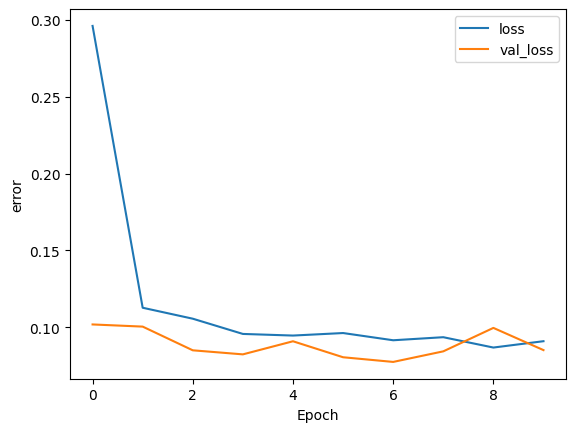

In [ ]:
def plot_learning(history, tgt='loss', val_tgt='val_loss', ylab='error'):
    plt.plot(history.history[tgt], label=tgt)
    plt.plot(history.history[val_tgt], label=val_tgt)
    plt.xlabel('Epoch')
    plt.ylabel(ylab)
    plt.legend()
plot_learning(history)
plt.show()

This cell evaluates the trained CNN model on the test data, X_test and y_test, then calculates the loss and accuracy on the test set and prints the test accuracy. This provides a final assessment of the model's performance on unseen data.

In [ ]:
test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)
print('\nTest accuracy:', test_acc)

6/6 - 13s - 2s/step - accuracy: 0.9705 - loss: 0.0852

Test accuracy: 0.9705148339271545


1. Cost/Loss Function:
- CNN Model: The code explicitly defines the loss function as binary_crossentropy during the compilation of the CNN model.

2. Modeling Architecture:
- CNN Model: The architecture of the CNN model is defined within the CNN class.

3. Hyperparameters:
- CNN Model: The code specifies the optimizer as adam and the number of training epochs as 10. These are hyperparameters that influence the training process. Other implicit hyperparameters include the learning rate of the optimizer, the batch size (if any is used during training), and the kernel sizes and number of filters in the convolutional layers.

4. Results and Performance Metrics:
- CNN Model: The code evaluates the CNN model using model.evaluate on the test data, providing the test loss and accuracy.